# Tarea 2

Integrantes:
* Juan Maulén 
* Pedro Pérez
* Tomás Rojas

In [1]:
from torchvision.datasets import DatasetFolder
import torch
import random
from PIL import Image
import numpy as np
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

In [8]:
def random_rotation(im, theta):
    theta = random.uniform(*theta)
    return im.rotate(theta)

def random_flip(im):
    if bool(random.getrandbits(1)):
        im.transpose(Image.FLIP_LEFT_RIGHT)
    return im
    
def normalize_im(im):
    im = np.asarray(im)
    
def loader(path):
    transformation = ToTensor()
    
    im = Image.open(path).resize((224, 224))  # escalamiento de la imagen
    im = random_flip(im)  # reflexion de la imagen
    im = random_rotation(im, (-20, 20))  # rotacion aleatoria de la imagen
    
    
    tensor = transformation(im)  # se transforma la imagen a un tensor
    if tensor.shape[0] == 1:
        tensor = tensor.repeat(3, 1, 1)
    
    rand_tensor = (1.5 - 1.2) * torch.rand((3, 224, 224)) + 1.2
    return tensor * rand_tensor


In [9]:
data_train = DatasetFolder('./chest_xray/train', loader=loader, extensions='.jpeg')
data_test = DatasetFolder('./chest_xray/test', loader=loader, extensions='.jpeg')

<BarContainer object of 2 artists>

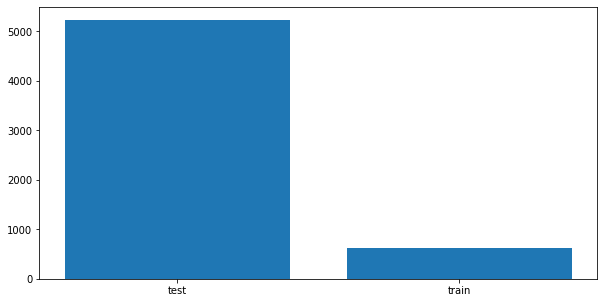

In [4]:
n_test = len(data_test)
n_train = len(data_train)
plt.figure(figsize=(10,5))
plt.bar(['test', 'train'], [n_train, n_test])

In [5]:
# train test split
train, test = len(data_train) - int(len(data_train) * .2),  int(len(data_train) * .2)  
train, test = torch.utils.data.random_split(data_train, [train, test])

In [6]:
#P2

In [7]:
#P3